In [1]:
# ==============================================================
# Beta-TCVAE + FiLM + Advanced Disentanglement Metrics
# ==============================================================

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm
import numpy as np
import random
from collections import defaultdict
from glob import glob
from PIL import Image
import lpips
import matplotlib.pyplot as plt
import timm
import pandas as pd # ✅ Added for robust binning

# ✅ Added Metrics Imports
from sklearn.metrics import silhouette_score, mutual_info_score
from scipy.stats import entropy

# --- 1. Configuration & Hyperparameters ---

GPU_ID = 0
DEVICE = torch.device(f'cuda:{GPU_ID}' if torch.cuda.is_available() else 'cpu')

DATA_DIR = '/home/juhyeong/AML/Data'
CVAE_MODEL_PATH = "best_cvae_beta_tcvae_TC4_hyperparameter.pth"

IMAGE_SIZE = 224
IMAGE_CHANNEL = 1
LATENT_DIM = 128
CLASSES = {0: 'Non Demented', 1: 'Very mild Dementia', 2: 'Mild Dementia'}
NUM_CLASSES = len(CLASSES)
CLASS_NAMES_MAP = {v: k for k, v in CLASSES.items()}
NUM_EPOCHS = 50
LEARNING_RATE = 1e-5
BATCH_SIZE = 32

# Loss weights
BETA_KLD_WEIGHT = 2.0
BCE_WEIGHT = 1.0
LAMBDA_LPIPS = 2.0
W_CENTER = 10.0
W_SEPARATION = 5.0
MARGIN = 2.0

# --- Beta-TCVAE Hyperparameters ---
TC_ALPHA = 1.0 
TC_BETA = 4.0   
TC_GAMMA = 1.0

# Classifier-guided loss
CLASSIFIER_LOSS_WEIGHT = 3.0

OUTPUT_FOLDER = "GEN_SAMPLES_BETA_TCVAE_TC4_HYPERPARAMETER"
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])


# ---------------------------------------------------------------
# Pretrained Classifier
# ---------------------------------------------------------------

class SimpleClassifier(nn.Module):
    def __init__(self, model_name='resnet18', num_classes=NUM_CLASSES):
        super().__init__()
        self.model = timm.create_model(
            model_name,
            pretrained=False,
            num_classes=num_classes,
            in_chans=1
        )

    def forward(self, x):
        return self.model(x)


def load_classifier(path="/home/juhyeong/AML/best_classifier_resnet18_weights_42.pth"):
    cls = SimpleClassifier(num_classes=NUM_CLASSES).to(DEVICE)
    ckpt = torch.load(path, map_location=DEVICE)
    cls.load_state_dict(ckpt)
    cls.eval()
    for p in cls.parameters():
        p.requires_grad = False
    return cls


# ---------------------------------------------------------------
# Dataset
# ---------------------------------------------------------------

class OASISContrastiveDataset(Dataset):
    def __init__(self, root_dir, transform=None, split='train', val_ratio=0.2, seed=42):
        self.transform = transform
        self.root_dir = root_dir
        self.data = []

        subject_to_imgs = defaultdict(list)

        for class_folder in os.listdir(root_dir):
            if class_folder not in CLASS_NAMES_MAP:
                continue
            class_label = CLASS_NAMES_MAP[class_folder]
            for img_path in glob(os.path.join(root_dir, class_folder, "*.jpg")):
                name = os.path.basename(img_path).split('.')[0]
                parts = name.split('_')
                subj = parts[1] if len(parts) > 1 else name
                subject_to_imgs[subj].append((img_path, class_label))

        self.subject_to_imgs = subject_to_imgs

        subject_main_label = {}
        for subj, items in subject_to_imgs.items():
            labels = [lbl for _, lbl in items]
            subject_main_label[subj] = max(set(labels), key=labels.count)

        random.seed(seed)
        class_to_subjects = defaultdict(list)
        for subj, lbl in subject_main_label.items():
            class_to_subjects[lbl].append(subj)

        train_subjects, val_subjects = [], []
        for lbl, subj_list in class_to_subjects.items():
            random.shuffle(subj_list)
            n_val = int(len(subj_list) * val_ratio)
            val_subjects.extend(subj_list[:n_val])
            train_subjects.extend(subj_list[n_val:])

        self.train_subjects = sorted(train_subjects)
        self.val_subjects = sorted(val_subjects)

        chosen = train_subjects if split == 'train' else val_subjects
        for subj in chosen:
            for img_path, lbl in subject_to_imgs[subj]:
                self.data.append((subj, img_path, lbl))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        subj, img_path, y = self.data[idx]
        img = Image.open(img_path).convert("L")
        if self.transform:
            img = self.transform(img)
        return img, y, subj


# ---------------------------------------------------------------
# Improved Latent Clustering Loss
# ---------------------------------------------------------------

class ImprovedClusteringLoss(nn.Module):
    def __init__(self, latent_dim: int, num_classes: int, margin: float = 2.0):
        super().__init__()
        self.num_classes = num_classes
        self.margin = margin
        self.centers = nn.Parameter(torch.randn(num_classes, latent_dim))
        nn.init.xavier_uniform_(self.centers)

    def forward(self, features: torch.Tensor, labels: torch.Tensor):
        centers_batch = self.centers[labels]
        center_loss = F.mse_loss(features, centers_batch)

        separation_loss = 0
        num_pairs = 0
        for i in range(self.num_classes):
            for j in range(i + 1, self.num_classes):
                dist = F.pairwise_distance(
                    self.centers[i].unsqueeze(0),
                    self.centers[j].unsqueeze(0)
                )
                separation_loss += F.relu(self.margin - dist)
                num_pairs += 1

        if num_pairs > 0:
            separation_loss = separation_loss / num_pairs

        return center_loss, separation_loss


# ---------------------------------------------------------------
# Beta-TCVAE Loss Function
# ---------------------------------------------------------------

def beta_tcvae_loss(z, mu, logv, alpha=1.0, beta=6.0, gamma=1.0):
    """
    Computes the decomposed KL loss for Beta-TCVAE.
    """
    batch_size, latent_dim = z.shape
    
    # 1. Compute log q(z|x) for all pairs
    # log q(z_i | x_j)
    log_q_zx_dim = -0.5 * (
        np.log(2 * np.pi) 
        + logv.unsqueeze(0) 
        + (z.unsqueeze(1) - mu.unsqueeze(0)) ** 2 / logv.exp().unsqueeze(0)
    )
    log_q_zx = log_q_zx_dim.sum(dim=2)
    
    # 2. Compute log q(z) (Marginal)
    log_q_z = torch.logsumexp(log_q_zx, dim=1) - np.log(batch_size)
    
    # 3. Compute log prod q(z_j) (Product of Marginals)
    log_q_z_dim = torch.logsumexp(log_q_zx_dim, dim=1) - np.log(batch_size)
    log_prod_q_z = log_q_z_dim.sum(dim=1)
    
    # 4. Compute log p(z) (Prior)
    log_p_z = -0.5 * (np.log(2 * np.pi) + z ** 2).sum(dim=1)
    
    # --- Terms ---
    mi_loss = (torch.diagonal(log_q_zx) - log_q_z).mean()
    tc_loss = (log_q_z - log_prod_q_z).mean()
    dw_kl_loss = (log_prod_q_z - log_p_z).mean()
    
    total_kld = alpha * mi_loss + beta * tc_loss + gamma * dw_kl_loss
    
    return total_kld, mi_loss, tc_loss, dw_kl_loss


# ---------------------------------------------------------------
# CVAE + FiLM Model
# ---------------------------------------------------------------

class FiLMCond(nn.Module):
    def __init__(self, embed_dim, num_features):
        super().__init__()
        self.scale = nn.Linear(embed_dim, num_features)
        self.shift = nn.Linear(embed_dim, num_features)

    def forward(self, h, class_emb):
        gamma = self.scale(class_emb).unsqueeze(-1).unsqueeze(-1)
        beta = self.shift(class_emb).unsqueeze(-1).unsqueeze(-1)
        return h * (1 + gamma) + beta

def up_block(cin, cout):
    return nn.Sequential(
        nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
        nn.Conv2d(cin, cout, 3, 1, 1),
        nn.BatchNorm2d(cout),
        nn.ReLU(inplace=True),
    )

class ImprovedCVAE(nn.Module):
    def __init__(self, latent_dim, img_size, img_channel, num_classes):
        super().__init__()

        self.latent_dim = latent_dim
        self.cls_dim = 32
        self.content_dim = latent_dim - self.cls_dim

        self.enc_conv1 = nn.Sequential(nn.Conv2d(img_channel, 32, 4, 2, 1), nn.BatchNorm2d(32), nn.ReLU())
        self.enc_conv2 = nn.Sequential(nn.Conv2d(32, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.ReLU())
        self.enc_conv3 = nn.Sequential(nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU())
        self.enc_conv4 = nn.Sequential(nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.ReLU())

        self.flat = 256 * 14 * 14
        self.fc_mu = nn.Linear(self.flat, latent_dim)
        self.fc_log = nn.Linear(self.flat, latent_dim)

        self.class_embed = nn.Embedding(num_classes, self.cls_dim)

        self.film1 = FiLMCond(self.cls_dim, 128)
        self.film2 = FiLMCond(self.cls_dim, 64)
        self.film3 = FiLMCond(self.cls_dim, 32)

        self.dec_fc = nn.Linear(latent_dim, self.flat)
        self.dec1 = up_block(256 + 128, 128)
        self.dec2 = up_block(128 + 64, 64)
        self.dec3 = up_block(64, 32)
        self.out = nn.Sequential(nn.Conv2d(32, 1, 3, 1, 1), nn.Sigmoid())

    def reparam(self, mu, logv):
        std = (0.5 * logv).exp()
        return mu + torch.randn_like(std) * std

    def forward(self, x, class_label):
        e1 = self.enc_conv1(x)
        e2 = self.enc_conv2(e1)
        e3 = self.enc_conv3(e2)
        e4 = self.enc_conv4(e3)

        h = e4.view(x.size(0), -1)
        mu = self.fc_mu(h)
        logv = self.fc_log(h)
        z = self.reparam(mu, logv)

        z_content = z[:, :self.content_dim]
        z_class_raw = z[:, self.content_dim:]
        class_emb = self.class_embed(class_label)

        z_final = torch.cat([z_content, class_emb], dim=1)

        d = self.dec_fc(z_final).view(x.size(0), 256, 14, 14)
        d = F.interpolate(d, size=e3.shape[2:], mode="bilinear")
        d = self.dec1(torch.cat([d, e3], dim=1))
        d = self.film1(d, class_emb)

        d = F.interpolate(d, size=e2.shape[2:], mode="bilinear")
        d = self.dec2(torch.cat([d, e2], dim=1))
        d = self.film2(d, class_emb)

        d = F.interpolate(d, size=(112, 112), mode="bilinear")
        d = self.dec3(d)
        d = self.film3(d, class_emb)

        out = self.out(F.interpolate(d, size=(224, 224), mode="bilinear"))

        return out, mu, logv, z_content, z_class_raw


# ---------------------------------------------------------------
# Helpers
# ---------------------------------------------------------------
lpips_fn = lpips.LPIPS(net='alex').to(DEVICE)
for p in lpips_fn.parameters():
    p.requires_grad = False

# ---------------------------------------------------------------
# Training Loop
# ---------------------------------------------------------------

def train_beta_tcvae(model, train_loader, val_loader, epochs, lr, lambda_recon, tc_alpha, tc_beta, tc_gamma, classifier):
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs)

    clustering_loss_fn = ImprovedClusteringLoss(
        latent_dim=model.cls_dim,
        num_classes=NUM_CLASSES,
        margin=MARGIN
    ).to(DEVICE)

    best_val_loss = 1e10
    patience = 20
    no_improve = 0

    for epoch in range(1, epochs + 1):
        model.train()
        pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}")
        
        for x, y, _ in pbar:
            x = x.to(DEVICE)
            y = y.to(DEVICE)

            opt.zero_grad()
            recon, mu, logv, z_content, z_class_raw = model(x, y)
            
            # Reconstruct full z for TC loss calculation
            z_full = torch.cat([z_content, z_class_raw], dim=1)

            # Beta-TCVAE Loss
            kld_weighted, mi, tc, dw_kl = beta_tcvae_loss(
                z_full, mu, logv, alpha=tc_alpha, beta=tc_beta, gamma=tc_gamma
            )

            bce = F.binary_cross_entropy(recon, x, reduction='mean')
            lp = lpips_fn(recon.repeat(1, 3, 1, 1), x.repeat(1, 3, 1, 1)).mean()
            center_loss, sep_loss = clustering_loss_fn(z_class_raw, y)

            recon_norm = (recon - 0.456) / 0.224
            cls_logits = classifier(recon_norm)
            cls_loss = F.cross_entropy(cls_logits, y)

            loss = (lambda_recon * bce +
                    kld_weighted +
                    LAMBDA_LPIPS * lp +
                    W_CENTER * center_loss +
                    W_SEPARATION * sep_loss +
                    CLASSIFIER_LOSS_WEIGHT * cls_loss)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()

            pbar.set_postfix({"loss": f"{loss.item():.3f}", "TC": f"{tc.item():.3f}"})

        scheduler.step()
        
        # Save best model based on TC or total loss
        if loss.item() < best_val_loss:
            best_val_loss = loss.item()
            torch.save({
                "model": model.state_dict(),
                "epoch": epoch,
                "val_loss": best_val_loss
            }, CVAE_MODEL_PATH)
            print("🔥 Saved best model")

    return clustering_loss_fn


# ---------------------------------------------------------------
# ✅ ADVANCED DISENTANGLEMENT EVALUATION
# ---------------------------------------------------------------

def discretize_latents(data, bins=20):
    """
    Discretizes continuous latent codes into bins for discrete entropy calculation.
    Uses quantile binning (qcut) to handle outliers/distributions robustly.
    """
    discretized = np.zeros_like(data, dtype=int)
    for i in range(data.shape[1]):
        # Drop duplicates allows dealing with collapsed dimensions (zero variance)
        discretized[:, i] = pd.qcut(data[:, i], q=bins, labels=False, duplicates='drop')
    return discretized

def calculate_advanced_metrics(model, loader, device):
    """
    Calculates Silhouette Score, MIG, and Modularity using Information Theory.
    Adapted for Beta-TCVAE Model.
    """
    model.eval()
    
    z_full_list = []
    z_class_list = []
    labels_list = []
    
    print("\n[Advanced Eval] Extracting latents for Disentanglement Analysis...")
    with torch.no_grad():
        for x, y, _ in tqdm(loader, desc="Encoding"):
            x = x.to(device)
            y = y.to(device)
            
            # Beta-TCVAE returns: out, mu, logv, z_content, z_class_raw
            _, _, _, z_content, z_class_raw = model(x, y)
            
            # Concatenate content and class to analyze the FULL latent structure
            z_full = torch.cat([z_content, z_class_raw], dim=1)
            
            z_full_list.append(z_full.cpu().numpy())
            z_class_list.append(z_class_raw.cpu().numpy())
            labels_list.append(y.cpu().numpy())
            
    Z_full = np.concatenate(z_full_list, axis=0)   # (N, 128)
    Z_class = np.concatenate(z_class_list, axis=0) # (N, 32)
    Y = np.concatenate(labels_list, axis=0)        # (N,)
    
    # -------------------------------------------------------------
    # Metric 1: Silhouette Score (Separability)
    # -------------------------------------------------------------
    print("  - Calculating Silhouette Score (Separability)...")
    # Use a subset for speed if dataset is huge (>10k)
    if len(Y) > 10000:
        indices = np.random.choice(len(Y), 10000, replace=False)
        sil_score = silhouette_score(Z_class[indices], Y[indices])
    else:
        sil_score = silhouette_score(Z_class, Y)

    # -------------------------------------------------------------
    # Metric 2: Mutual Information Gap (MIG) (Compactness)
    # -------------------------------------------------------------
    print("  - Calculating Mutual Information Gap (MIG)...")
    
    Z_discrete = discretize_latents(Z_full, bins=20)
    num_latents = Z_full.shape[1]
    
    _, counts = np.unique(Y, return_counts=True)
    entropy_y = entropy(counts)
    
    mi_scores = []
    for j in range(num_latents):
        mi = mutual_info_score(Z_discrete[:, j], Y)
        mi_scores.append(mi)
    mi_scores = np.array(mi_scores)
    
    sorted_mi = np.sort(mi_scores)[::-1]
    mig_score = (sorted_mi[0] - sorted_mi[1]) / entropy_y if entropy_y > 0 else 0

    # -------------------------------------------------------------
    # Metric 3: Modularity (Specialization)
    # -------------------------------------------------------------
    print("  - Calculating Modularity (Info Ratio)...")
    
    # In your architecture: 0-95 are Content, 96-127 are Class
    content_dim = 96
    mi_content = mi_scores[:content_dim]
    mi_class = mi_scores[content_dim:]
    
    total_info_content = np.sum(mi_content)
    total_info_class = np.sum(mi_class)
    
    modularity_ratio = total_info_class / (total_info_class + total_info_content + 1e-8)

    # -------------------------------------------------------------
    # Report
    # -------------------------------------------------------------
    print("\n" + "="*50)
    print(" ADVANCED DISENTANGLEMENT EVALUATION (Beta-TCVAE)")
    print("="*50)
    print(f"1. Silhouette Score: {sil_score:.4f}")
    print(f"   (Separability: >0.1 is okay, >0.5 is good clustering)")
    print("-" * 30)
    print(f"2. Mutual Info Gap (MIG): {mig_score:.4f}")
    print(f"   (Compactness: Higher is better. Measures single-neuron control.)")
    print("-" * 30)
    print(f"3. Modularity (Info Ratio): {modularity_ratio:.4f}")
    print(f"   (Specialization: Ratio of Class Info in z_class vs z_content)")
    print(f"   - Info in Content (Leakage): {total_info_content:.4f}")
    print(f"   - Info in Class Latents:     {total_info_class:.4f}")
    print("="*50 + "\n")
    
    return {
        "silhouette": sil_score,
        "mig": mig_score,
        "modularity": modularity_ratio
    }


# ---------------------------------------------------------------
# Image Generation Helpers
# ---------------------------------------------------------------
@torch.no_grad()
def generate_conditional_image(model, image, orig_label, target_label):
    model.eval()
    img = image.to(DEVICE).unsqueeze(0)
    target = torch.tensor([target_label], device=DEVICE)
    recon, _, _, _, _ = model(img, target)
    arr = (recon.squeeze().cpu().clamp(0, 1).numpy() * 255).astype(np.uint8)
    pil = Image.fromarray(arr, 'L')
    fname = f"from_{CLASSES[orig_label]}_to_{CLASSES[target_label]}_{np.random.randint(9999)}.png"
    path = os.path.join(OUTPUT_FOLDER, fname)
    pil.save(path)
    return path

@torch.no_grad()
def save_comparison(model, image, orig_label, target_label, save_path):
    model.eval()
    img = image.to(DEVICE).unsqueeze(0)
    target = torch.tensor([target_label], device=DEVICE)
    recon, _, _, _, _ = model(img, target)
    
    x0_np = image.squeeze().cpu().numpy()
    gen_np = recon.squeeze().cpu().clamp(0, 1).numpy()

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(x0_np, cmap='gray')
    plt.title(f"Original ({CLASSES[orig_label]})", fontsize=12)
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(gen_np, cmap='gray')
    plt.title(f"Generated ({CLASSES[target_label]})", fontsize=12)
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(save_path, dpi=100)
    plt.close()


/home/juhyeong/.conda/envs/cvae/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/juhyeong/.conda/envs/cvae/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/juhyeong/.conda/envs/cvae/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/juhyeong/.conda/envs/cvae/lib/python3.9/site-packages/lpips/weights/v0.1/alex.pth


In [2]:
# ---------------------------------------------------------------
# MAIN (Beta-TCVAE)
# ---------------------------------------------------------------

if __name__ == "__main__":

    # --- CONTROL FLAGS -----------------------------------------
    # Set this to True if you want to Train from scratch.
    # Set this to False if you just want to load the saved file and evaluate.
    TRAIN_MODE = False  
    # -----------------------------------------------------------

    # 1. Load Data
    train_dataset = OASISContrastiveDataset(DATA_DIR, transform=transform, split='train')
    val_dataset = OASISContrastiveDataset(DATA_DIR, transform=transform, split='val')

    print("\n--- Train subjects:", len(train_dataset.train_subjects))
    print("--- Val subjects:", len(val_dataset.val_subjects))

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

    # 2. Initialize Model Architecture
    model = ImprovedCVAE(
        LATENT_DIM, IMAGE_SIZE, IMAGE_CHANNEL,
        num_classes=NUM_CLASSES
    ).to(DEVICE)

    # 3. Load Classifier
    classifier = load_classifier()

    # 4. Logic Split: Train vs Load
    if TRAIN_MODE:
        print(f"\n🚀 Starting Beta-TCVAE Training (Epochs: {NUM_EPOCHS})...")
        print(f"   Hyperparams: Alpha={TC_ALPHA}, Beta={TC_BETA}, Gamma={TC_GAMMA}")
        
        # --- CORRECTED FUNCTION CALL ---
        clustering_loss_fn = train_beta_tcvae(
            model, train_loader, val_loader,
            epochs=NUM_EPOCHS, 
            lr=LEARNING_RATE,
            lambda_recon=BCE_WEIGHT,
            tc_alpha=TC_ALPHA,   # Mutual Information weight
            tc_beta=TC_BETA,     # Total Correlation weight (Disentanglement)
            tc_gamma=TC_GAMMA,   # Dimension-wise KL weight
            classifier=classifier
        )
    else:
        print(f"\n⏩ Skipping Training. Loading pre-trained model from {CVAE_MODEL_PATH}...")
        
        if os.path.exists(CVAE_MODEL_PATH):
            # Load model weights
            ckpt = torch.load(CVAE_MODEL_PATH, map_location=DEVICE)
            # Handle difference between full checkpoint dict vs state_dict only
            if "model" in ckpt:
                model.load_state_dict(ckpt["model"])
                epoch_info = ckpt.get('epoch', '?')
                loss_info = ckpt.get('val_loss', '?')
                print(f"✅ Successfully loaded model from epoch {epoch_info} (Val Loss: {loss_info})")
            else:
                model.load_state_dict(ckpt)
                print("✅ Successfully loaded model state dict.")
                
            # Optional: Initialize clustering loss container just for consistency if needed later
            clustering_loss_fn = ImprovedClusteringLoss(
                latent_dim=model.cls_dim, num_classes=NUM_CLASSES, margin=MARGIN
            ).to(DEVICE)
            
        else:
            raise FileNotFoundError(f"Could not find model at {CVAE_MODEL_PATH}. Set TRAIN_MODE = True first.")

    # 5. Run Advanced Disentanglement Analysis
    print("\n" + "#"*60)
    print(" STARTING ADVANCED DISENTANGLEMENT EVALUATION")
    print("#"*60)
    
    # Calculates Silhouette, MIG, and Modularity
    metrics = calculate_advanced_metrics(model, val_loader, DEVICE)

    # 6. Generate Samples
    print("\nGenerating sample image...")
    if len(val_dataset) > 0:
        x0, orig_label, _ = val_dataset[0]
        target = (orig_label + 1) % NUM_CLASSES
        
        # Generate
        gen_path = generate_conditional_image(model, x0, orig_label, target)
        print("Generated:", gen_path)

        # Save Comparison
        print("Generating comparison...")
        save_path = os.path.join(OUTPUT_FOLDER, "comparison_sample.png")
        save_comparison(model, x0, orig_label, target, save_path)
        print(f"Saved comparison figure to {save_path}")
    else:
        print("Validation dataset is empty, skipping generation.")


--- Train subjects: 277
--- Val subjects: 68

⏩ Skipping Training. Loading pre-trained model from best_cvae_beta_tcvae_TC4_hyperparameter.pth...
✅ Successfully loaded model from epoch 38 (Val Loss: 8.508737564086914)

############################################################
 STARTING ADVANCED DISENTANGLEMENT EVALUATION
############################################################

[Advanced Eval] Extracting latents for Disentanglement Analysis...


Encoding: 100%|██████████| 521/521 [00:12<00:00, 40.47it/s]


  - Calculating Silhouette Score (Separability)...
  - Calculating Mutual Information Gap (MIG)...
  - Calculating Modularity (Info Ratio)...

 ADVANCED DISENTANGLEMENT EVALUATION (Beta-TCVAE)
1. Silhouette Score: -0.0002
   (Separability: >0.1 is okay, >0.5 is good clustering)
------------------------------
2. Mutual Info Gap (MIG): 0.0002
   (Compactness: Higher is better. Measures single-neuron control.)
------------------------------
3. Modularity (Info Ratio): 0.2781
   (Specialization: Ratio of Class Info in z_class vs z_content)
   - Info in Content (Leakage): 0.1089
   - Info in Class Latents:     0.0419


Generating sample image...
Generated: GEN_SAMPLES_BETA_TCVAE_TC4_HYPERPARAMETER/from_Very mild Dementia_to_Mild Dementia_5750.png
Generating comparison...
Saved comparison figure to GEN_SAMPLES_BETA_TCVAE_TC4_HYPERPARAMETER/comparison_sample.png


/tmp/ipykernel_3615209/4085723117.py:528: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  pil = Image.fromarray(arr, 'L')


[Visualization] Extracting latents for distribution analysis...


Encoding: 100%|██████████| 521/521 [00:12<00:00, 41.24it/s]


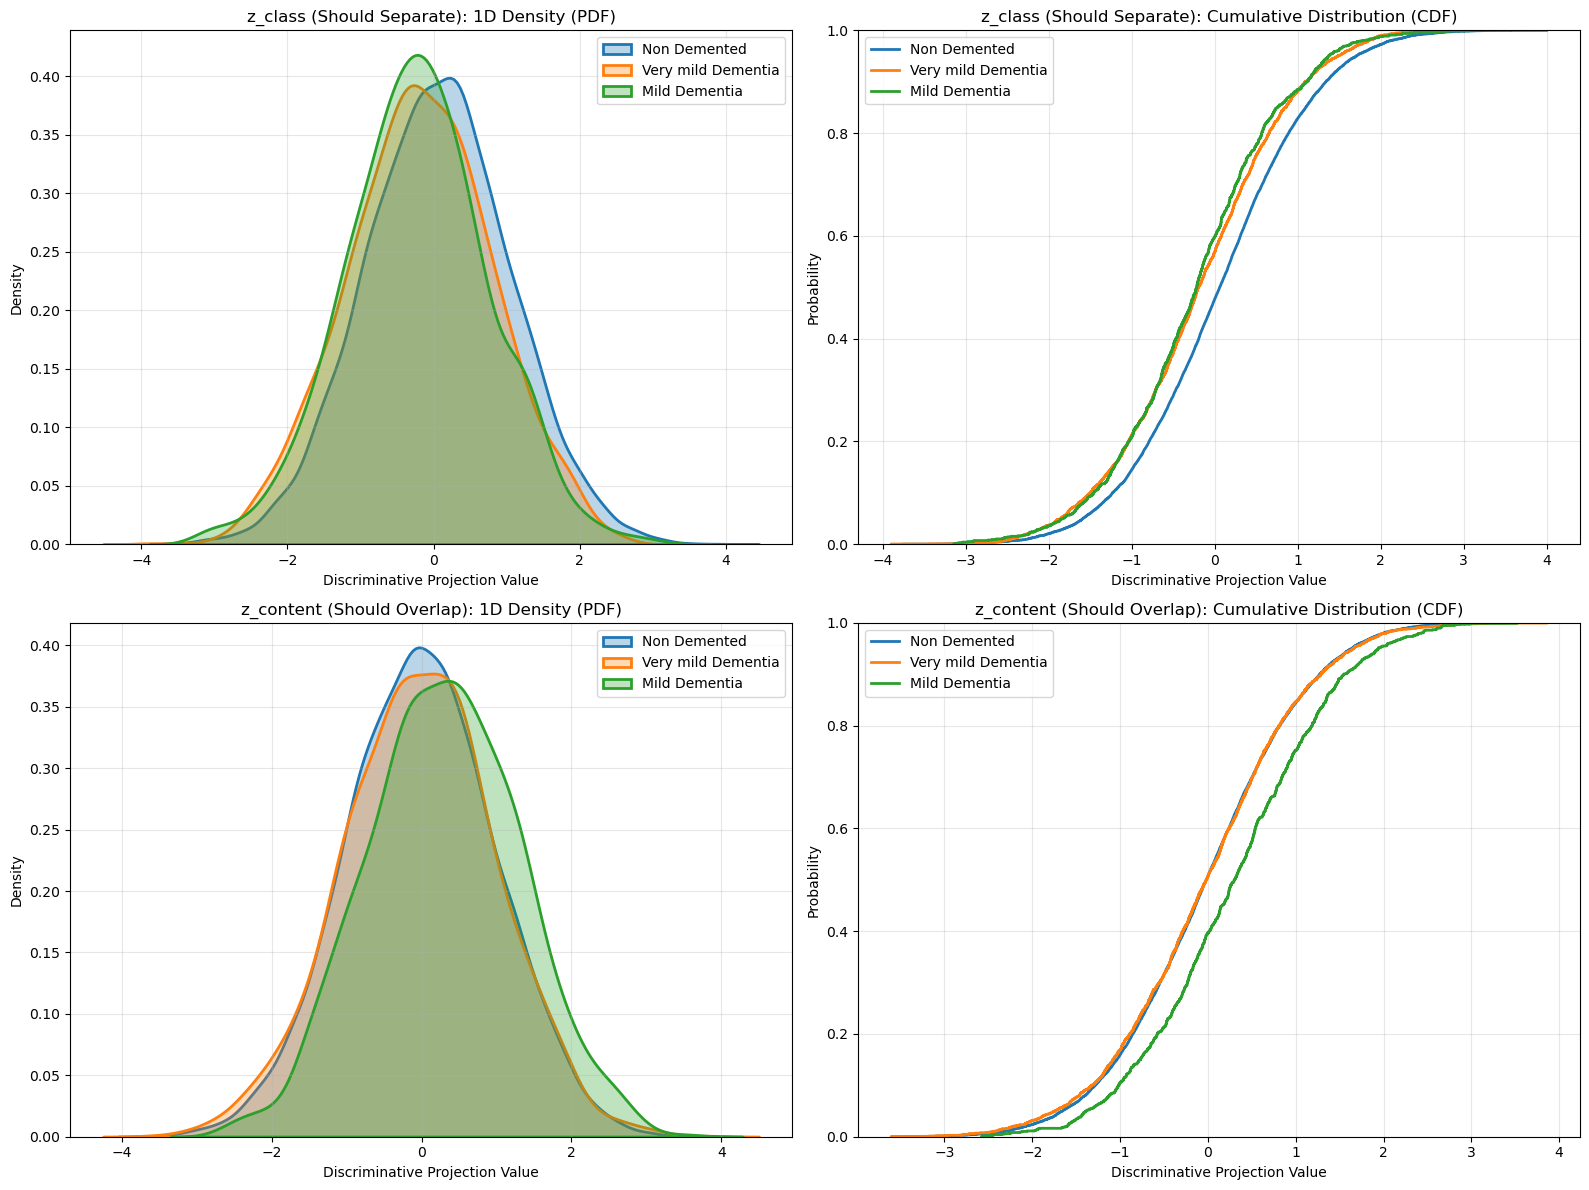

saved distribution plot to GEN_SAMPLES_BETA_TCVAE_TC4_HYPERPARAMETER/latent_distributions_1d.png


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler

def visualize_1d_overlap(model, loader, device):
    """
    Generates 1D PDF and CDF plots to visualize class overlap/separation.
    Uses LDA to project high-dim latents onto the most discriminative 1D axis.
    """
    model.eval()
    
    z_content_list = []
    z_class_list = []
    labels_list = []

    
    
    print("[Visualization] Extracting latents for distribution analysis...")
    with torch.no_grad():
        for x, y, _ in tqdm(loader, desc="Encoding"):
            x = x.to(device)
            y = y.to(device)
            
                        ## Get model output
            outputs = model(x, y)

            # Handle different return signatures dynamically
            if len(outputs) == 7:
                # Quantized CVAE: out, mu, logv, z_content, z_class_raw, q_loss, c_loss
                _, _, _, z_content, z_class_raw, _, _ = outputs
            elif len(outputs) == 5:
                # Vanilla CVAE: out, mu, logv, z_content, z_class_raw
                _, _, _, z_content, z_class_raw = outputs
            else:
                raise ValueError(f"Unexpected model output length: {len(outputs)}")
                        
            z_content_list.append(z_content.cpu().numpy())
            z_class_list.append(z_class_raw.cpu().numpy())
            labels_list.append(y.cpu().numpy())
            
    Z_content = np.concatenate(z_content_list, axis=0)
    Z_class = np.concatenate(z_class_list, axis=0)
    Y = np.concatenate(labels_list, axis=0)
    
    class_names = [CLASSES[i] for i in range(NUM_CLASSES)]
    
    # --- Helper to project and plot ---
    def plot_distributions(data, title_prefix, ax_pdf, ax_cdf):
        # 1. Project to 1D using LDA (Maximal Separation)
        # We want to see the 'best case' separation. If LDA can't separate them, nothing can.
        lda = LinearDiscriminantAnalysis(n_components=1)
        scaler = StandardScaler()
        data_scaled = scaler.fit_transform(data)
        
        # Fit LDA
        # Note: LDA requires at least 2 classes.
        z_projected = lda.fit_transform(data_scaled, Y).flatten()
        
        # 2. Plot PDF (KDE)
        for c in range(NUM_CLASSES):
            sns.kdeplot(
                z_projected[Y == c], 
                fill=True, 
                label=class_names[c], 
                alpha=0.3, 
                linewidth=2,
                ax=ax_pdf
            )
        ax_pdf.set_title(f"{title_prefix}: 1D Density (PDF)")
        ax_pdf.set_xlabel("Discriminative Projection Value")
        ax_pdf.set_ylabel("Density")
        ax_pdf.legend()
        ax_pdf.grid(True, alpha=0.3)
        
        # 3. Plot CDF
        for c in range(NUM_CLASSES):
            sns.ecdfplot(
                z_projected[Y == c], 
                label=class_names[c], 
                linewidth=2,
                ax=ax_cdf
            )
        ax_cdf.set_title(f"{title_prefix}: Cumulative Distribution (CDF)")
        ax_cdf.set_xlabel("Discriminative Projection Value")
        ax_cdf.set_ylabel("Probability")
        ax_cdf.legend()
        ax_cdf.grid(True, alpha=0.3)

    # --- Create Figure ---
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Row 1: z_class (We WANT separation here)
    plot_distributions(Z_class, "z_class (Should Separate)", axes[0, 0], axes[0, 1])
    
    # Row 2: z_content (We WANT overlap here)
    plot_distributions(Z_content, "z_content (Should Overlap)", axes[1, 0], axes[1, 1])
    
    plt.tight_layout()
    save_path = os.path.join(OUTPUT_FOLDER, "latent_distributions_1d.png")
    plt.savefig(save_path, dpi=150)
    plt.show()
    print(f"saved distribution plot to {save_path}")

# Run the visualization
visualize_1d_overlap(model, val_loader, DEVICE)

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

In [4]:
ANALYSIS_MEAN = torch.tensor([0.456]).view(1,1,1).to(DEVICE)
ANALYSIS_STD  = torch.tensor([0.224]).view(1,1,1).to(DEVICE)

CLASSES = {0:'Non Demented',1:'Very mild Dementia',2:'Mild Dementia'}

In [8]:
# ----------------------------------------------------------
# 1) Classification Model
# ----------------------------------------------------------
class PretrainedClassifier(nn.Module):
    def __init__(self, model_name='resnet18', num_classes=3, in_chans=1):
        super().__init__()
        self.model = timm.create_model(
            model_name,
            pretrained=False,
            num_classes=num_classes,
            in_chans=in_chans
        )

    def forward(self, x):
        return self.model(x)

def load_generated_image(path):
    img = Image.open(path).convert("L")
    img = transforms.ToTensor()(img)   # shape [1,224,224]
    return img

def load_classifier(model_path):
    model = PretrainedClassifier().to(DEVICE)
    state = torch.load(model_path, map_location=DEVICE)
    model.load_state_dict(state, strict=False)
    model.eval()
    return model


# ----------------------------------------------------------
# 2) Grad-CAM
# ----------------------------------------------------------
feature_map = None

def forward_hook(module, input, output):
    global feature_map
    feature_map = output
    feature_map.retain_grad()

def get_gradcam(model, img_norm, target_class):
    global feature_map
    feature_map = None

    target_layer = model.model.layer4
    hook = target_layer.register_forward_hook(forward_hook)

    out = model(img_norm.unsqueeze(0))

    if target_class is None:
        target_class = out.argmax(1).item()

    model.zero_grad()
    out[0, target_class].backward()

    hook.remove()

    fmap = feature_map.detach().cpu().numpy()[0]
    grad = feature_map.grad.detach().cpu().numpy()[0]

    weights = np.mean(grad, axis=(1,2))

    cam = np.zeros(fmap.shape[1:], dtype=np.float32)
    for c, w in enumerate(weights):
        cam += w * fmap[c]

    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (img_norm.size(2), img_norm.size(1)))
    cam -= cam.min()
    cam /= cam.max() + 1e-7
    return cam


# ----------------------------------------------------------
# 3) Visualization
# ----------------------------------------------------------
def visualize_gradcam(original_img_01, cam, pred_name, save_path):
    img = original_img_01.squeeze().cpu().numpy()

    heatmap = cv2.applyColorMap(np.uint8(cam*255), cv2.COLORMAP_JET)
    heatmap = heatmap[:, :, ::-1] / 255.0

    img3 = np.stack([img, img, img], axis=-1)
    overlay = 0.4*heatmap + 0.6*img3
    overlay = np.uint8(overlay*255)

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.imshow(img, cmap='gray')
    plt.title("Generated Image")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(overlay)
    plt.title(f"Grad-CAM ({pred_name})")
    plt.axis("off")   

    plt.subplots_adjust(wspace=0.05)
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()
    print(f"Saved Grad-CAM image: {save_path}")


# ----------------------------------------------------------
# 4) Main Runner (생성 이미지 전용)
# ----------------------------------------------------------
def run_gradcam_on_generated_image(gen_img_tensor, classifier_path):

    # load classifier
    clf = load_classifier(classifier_path)

    # normalize
    img_norm = (gen_img_tensor.to(DEVICE) - ANALYSIS_MEAN) / ANALYSIS_STD

    # classification
    with torch.no_grad():
        logits = clf(img_norm.unsqueeze(0))
        pred_id = logits.argmax(1).item()
        pred_name = CLASSES[pred_id]

    print(f"Predicted class: {pred_name}")

    # compute grad-cam
    cam = get_gradcam(clf, img_norm, pred_id)

    # save visualization
    visualize_gradcam(
        original_img_01=gen_img_tensor.cpu(),
        cam=cam,
        pred_name=pred_name,
        save_path=f"gradcam_generated_beta_tcvae_tc4_hyperparameter_{pred_name}.png"
    )


# ----------------------------------------------------------
# 5) 🔥 실제 호출
# ----------------------------------------------------------
# CVAE에서 생성한 이미지를 gen_img 라고 가정
# gen_img shape: [1, 224, 224]

# 예)
# gen,_,_,_ = model(x0, proto)
# gen_img = gen.squeeze(0)

# 🔥 실제 실행 코드
gen_img = load_generated_image("GEN_SAMPLES_BETA_TCVAE_TC4_HYPERPARAMETER/from_Very mild Dementia_to_Mild Dementia_8554.png")

run_gradcam_on_generated_image(
    gen_img_tensor = gen_img, 
    classifier_path = "/home/juhyeong/AML/best_classifier_resnet18_weights_42.pth"
)

Predicted class: Mild Dementia
Saved Grad-CAM image: gradcam_generated_beta_tcvae_tc4_hyperparameter_Mild Dementia.png


In [7]:
import torch
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# -----------------------------
# Config
# -----------------------------
CVAE_MODEL_PATH = "/home/juhyeong/AML/best_cvae_beta_tcvae_TC4_hyperparameter.pth"
BATCH_SIZE = 32
NUM_CLASSES = len(CLASSES)

# -----------------------------
# Load dataset
# -----------------------------
test_dataset = OASISContrastiveDataset(DATA_DIR, transform=transform, split='val')
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# -----------------------------
# Load CVAE
# -----------------------------
model = ImprovedCVAE(
    latent_dim=LATENT_DIM,
    img_size=224,
    img_channel=1,
    num_classes=NUM_CLASSES
).to(DEVICE)

ckpt = torch.load(CVAE_MODEL_PATH, map_location=DEVICE)
model.load_state_dict(ckpt["model"])
model.eval()

print(f"Loaded CVAE checkpoint (epoch {ckpt['epoch']}, val_loss={ckpt['val_loss']:.4f})")

# -----------------------------
# Collect latent vectors
# -----------------------------
lat_z_content = []
lat_z_class = []
labels = []

with torch.no_grad():
    for x, y, _ in test_loader:
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        
        # recon, mu, logv, z_content, z_class_raw
        _, _, _, zc, zcls = model(x, y)

        lat_z_content.append(zc.cpu())
        lat_z_class.append(zcls.cpu())
        labels.append(y.cpu())

lat_z_content = torch.cat(lat_z_content).numpy()
lat_z_class = torch.cat(lat_z_class).numpy()
labels = torch.cat(labels).numpy()

print("z_content shape:", lat_z_content.shape)
print("z_class_raw shape:", lat_z_class.shape)

# -----------------------------
# dimensionality reduction utils
# -----------------------------

def plot_2d(feats, labels, title, save_path):
    plt.figure(figsize=(7, 6))
    for cls_id, cls_name in CLASSES.items():
        idx = labels == cls_id
        plt.scatter(
            feats[idx, 0],
            feats[idx, 1],
            s=10, alpha=0.7,
            label=cls_name
        )
    plt.legend()
    plt.title(title)
    plt.tight_layout()
    plt.savefig(save_path, dpi=120)
    plt.close()
    print(f"Saved: {save_path}")

# -----------------------------
# PCA
# -----------------------------
pca = PCA(n_components=2)
pca_zc = pca.fit_transform(lat_z_content)
pca_zcls = pca.fit_transform(lat_z_class)

plot_2d(pca_zc, labels, "PCA of z_content_beta_tc4", "pca_z_content_beta_tc4__hyperparameter.png")
plot_2d(pca_zcls, labels, "PCA of z_class_raw_beta_tc4", "pca_z_class_beta_tc4__hyperparameter.png")

# -----------------------------
# t-SNE
# -----------------------------
tsne = TSNE(n_components=2, learning_rate="auto", init="random")

tsne_zc = tsne.fit_transform(lat_z_content)
tsne_zcls = tsne.fit_transform(lat_z_class)

plot_2d(tsne_zc, labels, "t-SNE of z_content_beta_tc4", "tsne_z_content_beta_tc4__hyperparameter.png")
plot_2d(tsne_zcls, labels, "t-SNE of z_class_raw_beta_tc4", "tsne_z_class_beta_tc4__hyperparameter.png")

print("Done. Saved PCA & t-SNE plots.")

Loaded CVAE checkpoint (epoch 38, val_loss=8.5087)
z_content shape: (16653, 96)
z_class_raw shape: (16653, 32)
Saved: pca_z_content_beta_tc4__hyperparameter.png
Saved: pca_z_class_beta_tc4__hyperparameter.png
Saved: tsne_z_content_beta_tc4__hyperparameter.png
Saved: tsne_z_class_beta_tc4__hyperparameter.png
Done. Saved PCA & t-SNE plots.


In [ ]:
print("Training and generation complete. Restarting kernel...")
%reset -f